In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

!pip3 install tensorflow -qqq
!pip3 install wandb -qqq
import wandb
!wandb login
from wandb.keras import WandbCallback

wandb: Currently logged in as: rohithd (use `wandb login --relogin` to force relogin)


In [2]:
import matplotlib.pyplot as plt

In [3]:
PROJECT_NAME = "CS6910 ASSIGNMENT 2"

In [4]:
cls={'Amphibia':0,
     'Animalia':1,
     'Arachnida':2,
     'Aves':3,
     'Fungi':4,
     'Insecta':5,
     'Mammalia':6,
     'Mollusca':7,
     'Plantae':8,
     'Reptilia':9}

In [5]:
from tensorflow.keras.preprocessing import image

run = wandb.init(project=PROJECT_NAME, job_type="inference")
# use the latest version of the model
model_at = run.use_artifact('rohithd/uncategorized/CNN:v0', type='model')
# 'krsrinivas/CS6910 ASSIGNMENT 2/CNN:v36', type='model'
# download the directory in which the model is saved
model_dir= model_at.download()
print("model: ", model_dir)
model = tf.keras.models.load_model(model_dir)

test_data_at = run.use_artifact('rohithd/CS6910 ASSIGNMENT 2/test_raw_data_2000:v0', type='raw_data')
test_dir = test_data_at.download()


wandb: Currently logged in as: rohithd (use `wandb login --relogin` to force relogin)


model:  ./artifacts/CNN:v0


wandb: Downloading large artifact test_raw_data_2000:v0, 604.34MB. 2000 files... Done. 0:0:0


In [6]:

imgs = []
true_pred=[]
class_labels = os.listdir(test_dir)
for l in class_labels:
  if l.startswith("."):
    continue
  imgs_per_class = os.listdir(os.path.join(test_dir, l))
  for img in imgs_per_class:
    img_path = os.path.join(test_dir, l, img)
    if img_path[-4:]!=".jpg":
      continue
    img = image.load_img(img_path, target_size=(229, 229))
    img = image.img_to_array(img)
    # don't forget to rescale test images to match the range of inputs
    # to the network
    img = np.expand_dims(img/255.0, axis=0)
    imgs.append(img)
    true_pred.append(cls[l])
imgs = np.vstack(imgs)

In [7]:

preds = {}
classes = model.predict(imgs[:200], batch_size=32)
for c in classes:
  class_id = np.argmax(c)
  if class_id in preds:
    preds[class_id] += 1
  else:
    preds[class_id] = 1

# print the counts of predicted labels as a quick sanity check
# note that for tiny/medium datasets, this won't be very meaningful
print(preds)
run.finish()

{5: 28, 6: 37, 3: 75, 9: 5, 8: 27, 2: 15, 1: 4, 4: 6, 0: 3}


In [23]:
true_pred_vector=np.zeros((np.shape(true_pred)[0],10))
for i,true_val in enumerate(true_pred):
  true_pred_vector[i,true_val]=1
true_pred_vector=np.array(true_pred_vector)

In [25]:
model.evaluate(imgs,true_pred_vector)

63/63 [==============================] - 84s 1s/step - loss: 2.0560 - accuracy: 0.3555


[2.056029796600342, 0.3555000126361847]

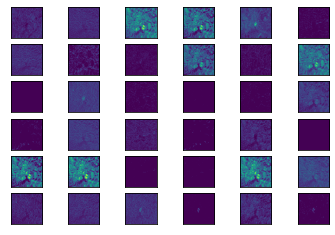

In [11]:
from numpy import random
from keras.models import Model

modelConv1=Model(inputs=model.inputs, outputs=model.layers[0].output)

# take a random image "img"
img= np.expand_dims(imgs[random.randint(0,2000)], axis=0)

preds=modelConv1.predict(img,batch_size=32)
square = 6
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(preds[0, :, :, ix-1], cmap='viridis')
		ix += 1
# show the figure
plt.show()

In [12]:
layer_name="conv2d_4"

layer = model.get_layer(name=layer_name)
feature_extractor = Model(inputs=model.inputs, outputs=layer.output)


In [19]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img

def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img


In [21]:
def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.1

    # Center crop
    #img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

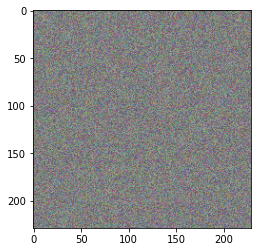

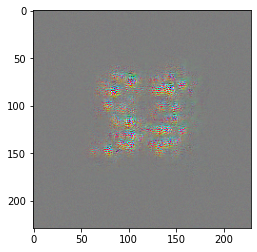

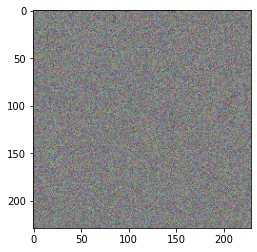

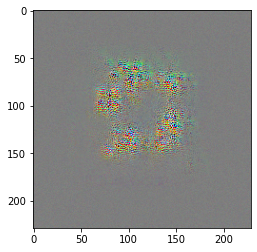

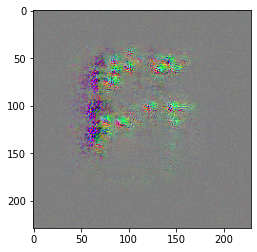

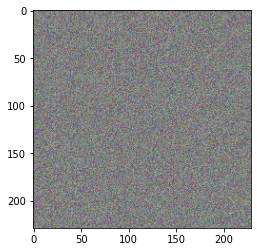

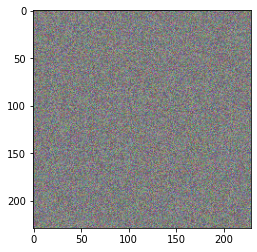

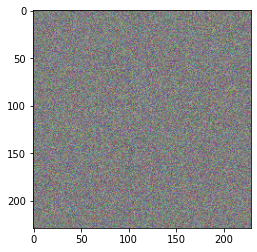

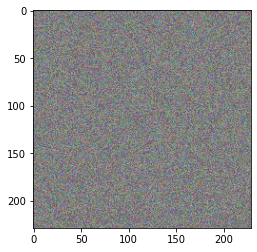

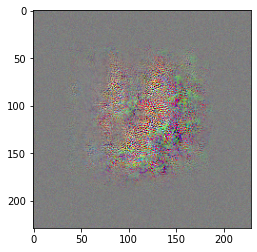

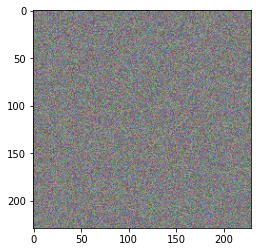

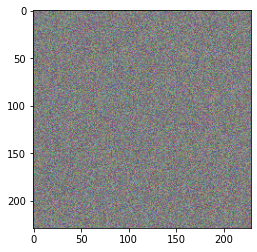

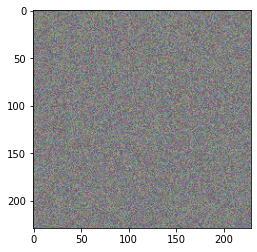

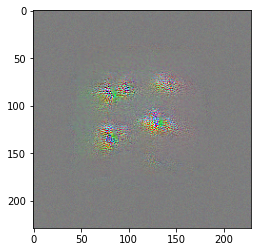

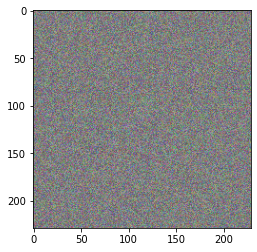

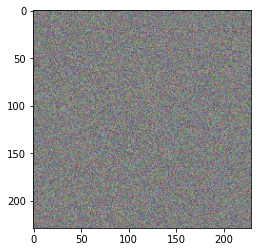

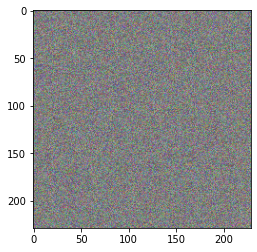

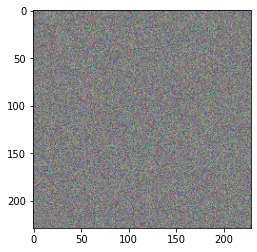

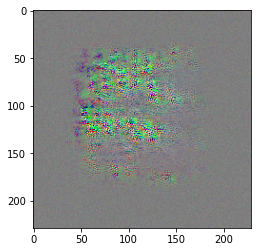

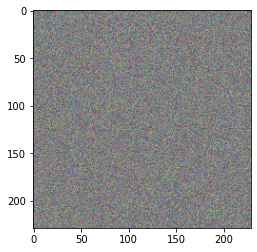

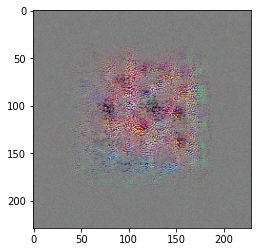

In [ ]:
img_width, img_height=229,229

for i in range(100):
  loss, img = visualize_filter(i)
  plt.imshow(img)
  plt.show()